In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import torch
import albumentations as alb
from torchvision.transforms import functional as F
from torchvision import transforms
from cnn_finetune import make_model

import model as M
from data import *
from util import *

In [3]:
torch.cuda.is_available()

True

In [12]:
x = torch.Tensor(np.random.rand(3, 1, 4, 4))
y = torch.Tensor(np.random.rand(3, 1, 4, 4))
z = torch.Tensor(np.random.rand(3, 1, 4, 4))
w = torch.Tensor(np.zeros((3, 1, 4, 4)))

w = w + x + y + z
w.cpu() / 3

tensor([[[[0.4414, 0.5343, 0.4405, 0.3138],
          [0.3177, 0.3541, 0.7964, 0.3496],
          [0.3432, 0.6278, 0.1571, 0.6501],
          [0.3319, 0.1795, 0.8755, 0.7865]]],


        [[[0.6178, 0.4875, 0.8386, 0.5412],
          [0.5234, 0.3610, 0.9239, 0.5615],
          [0.5391, 0.4170, 0.7311, 0.3489],
          [0.7224, 0.3581, 0.3823, 0.5223]]],


        [[[0.4176, 0.3392, 0.5691, 0.3178],
          [0.5602, 0.6336, 0.4081, 0.6378],
          [0.4440, 0.6724, 0.6420, 0.6788],
          [0.4530, 0.6365, 0.5920, 0.7328]]]])

# Show dataset

In [4]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)
depth_df = pd.read_csv(depth_csv)

train_df = pd.merge(train_df, depth_df, on='id')
test_df = pd.merge(test_df, depth_df, on='id')

## rle_mask NaN case

In [5]:
train_df.iloc[0]

id          575d24d81d
rle_mask           NaN
z                  843
Name: 0, dtype: object

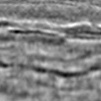

In [6]:
get_train_image(train_df.iloc[0]['id'])

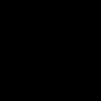

In [8]:
get_train_mask(train_df.iloc[0]['id'])

## rle_mask exists case

In [8]:
train_df.iloc[2]

id                                                 75efad62c1
rle_mask    9 93 109 94 210 94 310 95 411 95 511 96 612 96...
z                                                         468
Name: 2, dtype: object

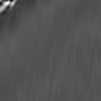

In [9]:
get_train_image(train_df.iloc[2]['id'])

In [14]:
mask = get_train_mask(train_df.iloc[2]['id'])
mask = np.array(mask, dtype=np.uint8) / 255

dtype('float64')

# Test rle_encoding method

In [8]:
transformer = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [9]:
mask_im = get_train_mask(train_df.iloc[3]['id'])
mask_im = transformer(mask_im)
mask_im = mask_im > 0.5
mask_im

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]], dtype=torch.uint8)

In [10]:
im1 = get_train_image(train_df.iloc[3]['id'])
im2 = get_train_image(train_df.iloc[4]['id'])

im1 = transformer(im1)
im2 = transformer(im2)

im = torch.cat([im1, im2]).reshape(2, 1, 128, 128)

to_pil = transforms.ToPILImage()
resize = transforms.Resize((101, 101))

np.array([np.array(resize(to_pil(_))) for _ in im]).reshape(2, 1, 101, 101)

array([[[[134, 119, 101, ..., 155, 158, 162],
         [131, 114,  94, ..., 154, 157, 162],
         [127, 108,  86, ..., 151, 156, 163],
         ...,
         [107, 111, 114, ..., 159, 171, 178],
         [110, 113, 116, ..., 156, 163, 164],
         [113, 116, 118, ..., 153, 154, 150]]],


       [[[ 19,  21,  24, ...,  89,  80,  73],
         [ 29,  29,  28, ...,  81,  73,  67],
         [ 48,  45,  43, ...,  74,  68,  64],
         ...,
         [146, 149, 152, ..., 166, 168, 170],
         [177, 179, 182, ..., 169, 171, 173],
         [204, 206, 208, ..., 173, 176, 178]]]], dtype=uint8)

In [91]:
rle_encode(mask_im.numpy()) == RLenc(mask_im.numpy())

True

In [92]:
%%timeit
rle_encode(mask_im.numpy())

117 µs ± 994 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [93]:
%%timeit
RLenc(mask_im.numpy())

20.8 ms ± 271 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Check add_depth_channels

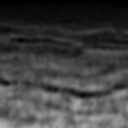

In [97]:
im = get_train_image(train_df.iloc[0]['id'])
im = transformer(im)
im = add_depth_channels(im)
im = (im[2].reshape((1, 128, 128)) * 255).astype(np.uint8)
im = np.array([im[0], im[0], im[0]])
im = im.transpose((1, 2, 0))
Image.fromarray(im)

# Check model

In [94]:
model = M.UNet(1, 2)

In [95]:
im = get_train_image(train_df.iloc[102]['id'])
im = transformer(im)
im = im.expand(1, *im.shape)
y = model(im)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\modules\upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [96]:
y.shape

torch.Size([1, 2, 128, 128])

In [60]:
im = get_train_image(train_df.iloc[0]['id'])
im

AttributeError: 'PngImageFile' object has no attribute 'shape'

In [122]:
(np.array(im.rotate(90)) == np.array(im)).all()

False

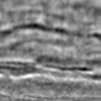

In [123]:
im.rotate(180)

In [9]:
x = np.random.rand(16, 1, 101, 101)
y = np.random.rand(16, 1, 101, 101)
z = np.empty((0, 1, 101, 101))

In [10]:
z = np.concatenate([z, x])

In [12]:
z = np.concatenate([z, y])

In [14]:
z.shape

(32, 1, 101, 101)

# albumentations

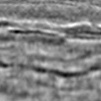

In [10]:
im = get_train_image(train_df.iloc[0]['id'])
im

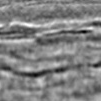

In [24]:
aug = alb.HorizontalFlip(p=1)
#np.transpose(aug(image=np.array(im))['image'], (2, 0, 1))
Image.fromarray(aug(image=np.array(im))['image'])

In [29]:
aug(transforms.ToTensor()(transforms.Grayscale()(im)))

TypeError: __call__() takes 1 positional argument but 2 were given

In [98]:
aug = alb.Compose([
    alb.RandomSizedCrop(min_max_height=(80, 101), height=101, width=101, p=0.5),
    alb.HorizontalFlip(p=0.5),
    alb.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    alb.GridDistortion(p=0.5),
    alb.Blur(),
    alb.GaussNoise(),
    alb.RandomBrightness(),
    alb.RandomGamma()
])

In [108]:
im = get_train_image(train_df.iloc[102]['id'])
mask = get_train_mask(train_df.iloc[102]['id'])
augmented = aug(image=np.array(im), mask=np.array(mask))

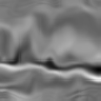

In [114]:
transforms.ToPILImage()(transforms.ToTensor()(transforms.Grayscale()(Image.fromarray(augmented['image']))))

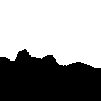

In [110]:
Image.fromarray(augmented['mask'])

In [111]:
augmented['image'].shape

(101, 101, 3)

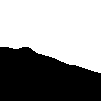

In [61]:
get_train_mask(train_df.iloc[102]['id'])

In [78]:
alb.RandomSizedCrop?

'<albumentations.core.composition.Compose object at 0x000001EBE2AE6860>'